In [211]:
import numpy as np
import os
import spacy
import pandas as pd
from tqdm import tqdm 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from spacy.lang.en import English
import random
from collections import Counter

In [212]:
df = pd.read_excel('BetaData.xlsx')

In [213]:
ALPHA = 0.5
BETA = 0.5
NUM_TOPICS = 40
sp = spacy.load('en_core_web_sm')

np.random.seed(100)
random.seed(100)

In [214]:
def generate_frequencies(data, max_docs = 10000):
    freqs = Counter()
    all_stopwords = sp.Defaults.stop_words
    all_stopwords.add('okidoki')
    all_stopwords.add('hey')
    all_stopwords.add('yep')
    all_stopwords.add('girl')
    all_stopwords.add('na')
    all_stopwords.add('nuh')
    all_stopwords.add('null')
    all_stopwords.add('yoh')
    all_stopwords.add('okay')
    all_stopwords.add('yup')
    all_stopwords.add('eish')
    all_stopwords.add('ai')
    all_stopwords.add('sure')
    all_stopwords.add('oh')
    all_stopwords.add('hi')
    all_stopwords.add('nope')
    all_stopwords.add('awe')
    all_stopwords.add('https')
    all_stopwords.add('ah')
    all_stopwords.add('heyo')
    all_stopwords.add('whoop')
    all_stopwords.add('yeah')
    all_stopwords.add('gon')
    all_stopwords.add('said')
    all_stopwords.add('yes')
    all_stopwords.add('know')
    all_stopwords.add("enron")
    nr_tokens = 0

    for doc in data[:max_docs]:
        if isinstance(doc, str):
            tokens = sp.tokenizer(doc)
            for token in tokens:
                token_text = token.text.lower()
                if token_text not in all_stopwords and token.is_alpha:
                    nr_tokens += 1
                    freqs[token_text] += 1
        else:
            continue

    return freqs

def get_vocab(freqs, freq_threshold=3):
    vocab = {}
    vocab_idx_str = {}
    vocab_idx = 0

    for word in freqs:
        if freqs[word] >= freq_threshold:
            vocab[word]= vocab_idx
            vocab_idx_str[vocab_idx] = word
            vocab_idx += 1
    return vocab, vocab_idx_str
        


def tokenize_dataset(data, vocab, max_docs= 10000):
    nr_tokens = 0
    nr_docs = 0
    docs = []

    for doc in data[:max_docs]:
        tokens = sp.tokenizer(doc)

        if len(tokens) > 1:
            doc = []
            for token in tokens:
                token_text = token.text.lower()
                if token_text in vocab:
                    doc.append(token_text)
                    nr_tokens += 1
            nr_docs += 1
            docs.append(doc)

    print(f"Number of text messages: {nr_docs}")
    print(f"Number of tokens: {nr_tokens}")

    corpus = []
    for doc in docs:
        corpus_d = []

        for token in doc:
            corpus_d.append(vocab[token])

        corpus.append(np.asarray(corpus_d))

    return docs, corpus


In [215]:
data = df['Column1'].astype(str).sample(frac=1).values
freqs = generate_frequencies(data)
vocab, vocab_idx_str = get_vocab(freqs)
docs, corpus = tokenize_dataset(data, vocab)
vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")

Number of text messages: 1425
Number of tokens: 1335
Vocab size: 221


In [216]:
def LDA_Collapsed_Gibbs(corpus, num_iter=200):

    Z = []
    num_docs = len(corpus)

    for _, doc in enumerate(corpus):
        Zd = np.random.randint(low=0, high = NUM_TOPICS, size=(len(doc)))
        Z.append(Zd)

    ndk = np.zeros((num_docs, NUM_TOPICS))
    for d in range(num_docs):
        for k in range(NUM_TOPICS):
            ndk[d, k] = np.sum(Z[d]==k)

    nkw = np.zeros((NUM_TOPICS, vocab_size))
    for doc_idx, doc in enumerate(corpus):
        for i, word in enumerate(doc):
            topic = Z[doc_idx][i]
            nkw[topic, word] += 1

    nk = np.sum(nkw, axis=1)
    topic_list = [i for i in range(NUM_TOPICS)]

    for _ in tqdm(range(num_iter)):
        for doc_idx, doc in enumerate(corpus):
            for i in range(len(doc)):
                word = doc[i]
                topic = Z[doc_idx][i]

                ndk[doc_idx, topic] -= 1
                nkw[topic, word] -= 1
                nk[topic] -= 1

                p_z = (ndk[doc_idx, :] + ALPHA * (nkw[:, word] + BETA)/ (nk[:] + BETA*vocab_size))
                topic = random.choices(topic_list, weights=p_z, k=1)[0]

                Z[doc_idx][i] = topic
                ndk[doc_idx, topic] += 1
                nkw[topic, word] += 1
                nk[topic] += 1

    return Z, ndk, nkw, nk

Z, ndk, nkw, nk = LDA_Collapsed_Gibbs(corpus)


100%|██████████| 200/200 [00:02<00:00, 95.79it/s]


In [217]:


phi = nkw / nk.reshape(NUM_TOPICS, 1)

num_words = 15
for k in range(NUM_TOPICS):
    most_common_words = np.argsort(phi[k])[::-1][:num_words]
    print(f"Topic {k} most common words: ")

    for word in most_common_words:
        print(vocab_idx_str[word])

    print("\n")


Topic 0 most common words: 
way
dumb
coming
time
better
wants
nah
delivery
sending
mind
thinking
trust
study
getting
paid


Topic 1 most common words: 
morning
today
time
send
happened
better
t
paid
worry
wanted
email
tomorrow
soon
tight
sleep


Topic 2 most common words: 
meet
page
laundry
chat
vn
listen
class
story
week
paid
mind
moment
year
crime
missed


Topic 3 most common words: 
thought
kill
send
year
tomorrow
tell
soon
tonight
weekend
moving
skipping
pick
told
excited
date


Topic 4 most common words: 
year
happy
let
going
new
hope
friend
delivery
pick
t
try
wrong
gate
happened
desk


Topic 5 most common words: 
outside
saying
wait
right
asked
talk
pay
meeting
leaving
hope
mind
google
started
soon
apartment


Topic 6 most common words: 
sorry
want
work
like
coming
told
think
forward
thing
change
text
outside
talking
got
hope


Topic 7 most common words: 
saw
ready
leave
time
let
update
things
friend
peanut
soon
sent
lost
got
actually
best


Topic 8 most common words: 
home
brin

In [218]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns

# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Column1'].values.astype('U'))

# Apply LDA
n_topics = 10  # Adjust the number of topics as needed
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

# Get the topics
topics = lda.components_


In [219]:

# Get the top words for each topic
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
topic_words = {}

for topic_idx, topic in enumerate(topics):
    topic_words[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]

# Print the topics
for topic_idx, words in topic_words.items():
    print(f"Topic {topic_idx}: {', '.join(words)}")


Topic 0: ll, happened, need, eh, send, make, bring, didn, say, time
Topic 1: morning, going, just, good, home, tonight, tomorrow, wanna, alright, gym
Topic 2: coming, gonna, missed, say, voice, did, sushi, let, 19, cause
Topic 3: yes, https, like, don, sorry, start, mind, come, know, mean
Topic 4: know, let, don, ll, just, come, meet, yep, lecture, heyo
Topic 5: null, nan, ll, outside, yoh, just, come, maybe, desk, carry
Topic 6: hey, girl, time, sure, whoop, friday, way, working, hatfield, quick
Topic 7: okay, thank, oh, meeting, said, ll, work, doing, time, tomorrow
Topic 8: kay, ll, just, apartment, yup, nope, ready, uber, hello, better
Topic 9: yeah, year, ll, think, getting, did, just, tell, happy, asked


In [220]:

# Define good and bad words for classification
good_words = set(['improving', 'growth', 'advancements', 'exciting', 'communities', 'emerging', 'better', 'outcomes', 'promising', 'renewable','happy', 'joy', 'joyful', 'delighted', 'cheerful', 'blissful', 'content', 'contented', 'pleased', 'ecstatic', 'elated', 'euphoric', 'jubilant', 'overjoyed', 'radiant', 'upbeat', 'satisfied', 'gratified', 'thrilled', 'exuberant', 'positive', 'wonderful', 'amazing', 'fantastic', 'great', 'splendid', 'marvelous', 'awesome', 'terrific', 'bliss', 'happiness', 'enjoyment', 'pleasure', 'glad', 'smile', 'laughter', 'celebrate', 'celebration', 'merry', 'fortunate', 'lucky', 'blessed', 'fulfilled', 'cheerful', 'hopeful', 'optimistic', 'grateful', 'thankful', 'appreciative', 'admire', 'admired', 'admiration', 'love', 'loving', 'caring', 'kind', 'kindness', 'compassion', 'compassionate', 'benevolent', 'generous', 'charitable', 'altruistic', 'noble', 'honorable', 'respectful', 'respected', 'dignified', 'courteous', 'polite', 'thoughtful', 'considerate', 'understanding', 'supportive', 'encouraging', 'helpful', 'dependable', 'reliable', 'trustworthy', 'faithful', 'loyal', 'dedicated', 'committed', 'devoted', 'passionate', 'enthusiastic', 'energetic', 'vigorous', 'dynamic', 'lively', 'spirited', 'vivacious', 'bright', 'brilliant', 'intelligent', 'smart', 'wise', 'insightful', 'perceptive', 'creative', 'imaginative', 'innovative', 'inspired', 'talented', 'skilled', 'proficient', 'accomplished', 'successful', 'achieving', 'victorious', 'triumphant', 'brave', 'courageous', 'bold', 'fearless', 'valiant', 'resilient', 'strong', 'determined', 'persistent', 'tenacious', 'ambitious', 'motivated', 'righteous', 'integrity', 'principled', 'idealistic', 'visionary', 'dreamer', 'aspirational', 'inspiring', 'motivational', 'encouraging', 'uplifting', 'hopeful', 'promising', 'bright', 'optimistic', 'sunny', 'cheerful', 'joyous', 'gleeful', 'mirthful', 'jolly', 'elated'])
bad_words = set(['murder', 'homicide', 'killing', 'yoh','kill', 'manslaughter', 'assassination', 'slaying', 'massacre', 'crime', 'victim', 'perpetrator', 'suspect', 'weapon', 'gun', 'knife', 'blood', 'death', 'violence', 'fatal', 'body', 'corpse', 'crime scene', 'investigation', 'detective', 'forensic', 'autopsy', 'motive', 'arrest', 'charge', 'convict', 'trial', 'witness', 'evidence', 'testimony', 'prosecutor', 'defense', 'judge', 'jury', 'sentence', 'prison', 'jail', 'felony', 'misdemeanor', 'burglary', 'robbery', 'theft', 'larceny', 'fraud', 'embezzlement', 'assault', 'battery', 'kidnapping', 'abduction', 'arson', 'vandalism', 'terrorism', 'smuggling', 'trafficking', 'drug', 'narcotics', 'abuse', 'addiction', 'gang', 'organized crime', 'cybercrime', 'white-collar crime', 'extortion', 'bribery', 'corruption', 'blackmail', 'insider trading', 'identity theft', 'money laundering', 'racketeering', 'hit-and-run', 'DUI', 'drunk driving', 'vehicular manslaughter', 'parole', 'probation', 'escape', 'fugitive', 'wanted', 'mugshot', 'booking', 'bail', 'bond', 'custody', 'interrogation', 'confession', 'plea', 'plea bargain', 'sentencing', 'appeal', 'incarceration', 'rehabilitation', 'recidivism', 'parole board', 'probation officer', 'parole officer', 'criminal record', 'background check'])

# Classify topics
def classify_topic(words):
    if any(word in good_words for word in words):
        return 'good'
    elif any(word in bad_words for word in words):
        return 'bad'
    else:
        return 'neutral'

classified_topics = {topic_idx: classify_topic(words) for topic_idx, words in topic_words.items()}

# Print classified topics
for topic_idx, classification in classified_topics.items():
    print(f"Topic {topic_idx} is classified as {classification}")

# Adding topic classification back to the dataframe
def get_document_topic(lda, X):
    return np.argmax(lda.transform(X), axis=1)

df['topic'] = get_document_topic(lda, X)
df['classification'] = df['topic'].apply(lambda x: classified_topics[x])

print(df)



Topic 0 is classified as neutral
Topic 1 is classified as neutral
Topic 2 is classified as neutral
Topic 3 is classified as neutral
Topic 4 is classified as neutral
Topic 5 is classified as bad
Topic 6 is classified as neutral
Topic 7 is classified as neutral
Topic 8 is classified as good
Topic 9 is classified as good
                                            Column1  topic classification
0                                           Tshego?      9           good
1                                         Hello❤️❤️      8           good
2               😎 nevermind, love. I figured it out      4        neutral
3                             A skirt in this cold🥶      6        neutral
4                                                 👗      0        neutral
...                                             ...    ...            ...
1643                   I'll give you feedback at 15      5            bad
1644                                                     0        neutral
1645        Ar

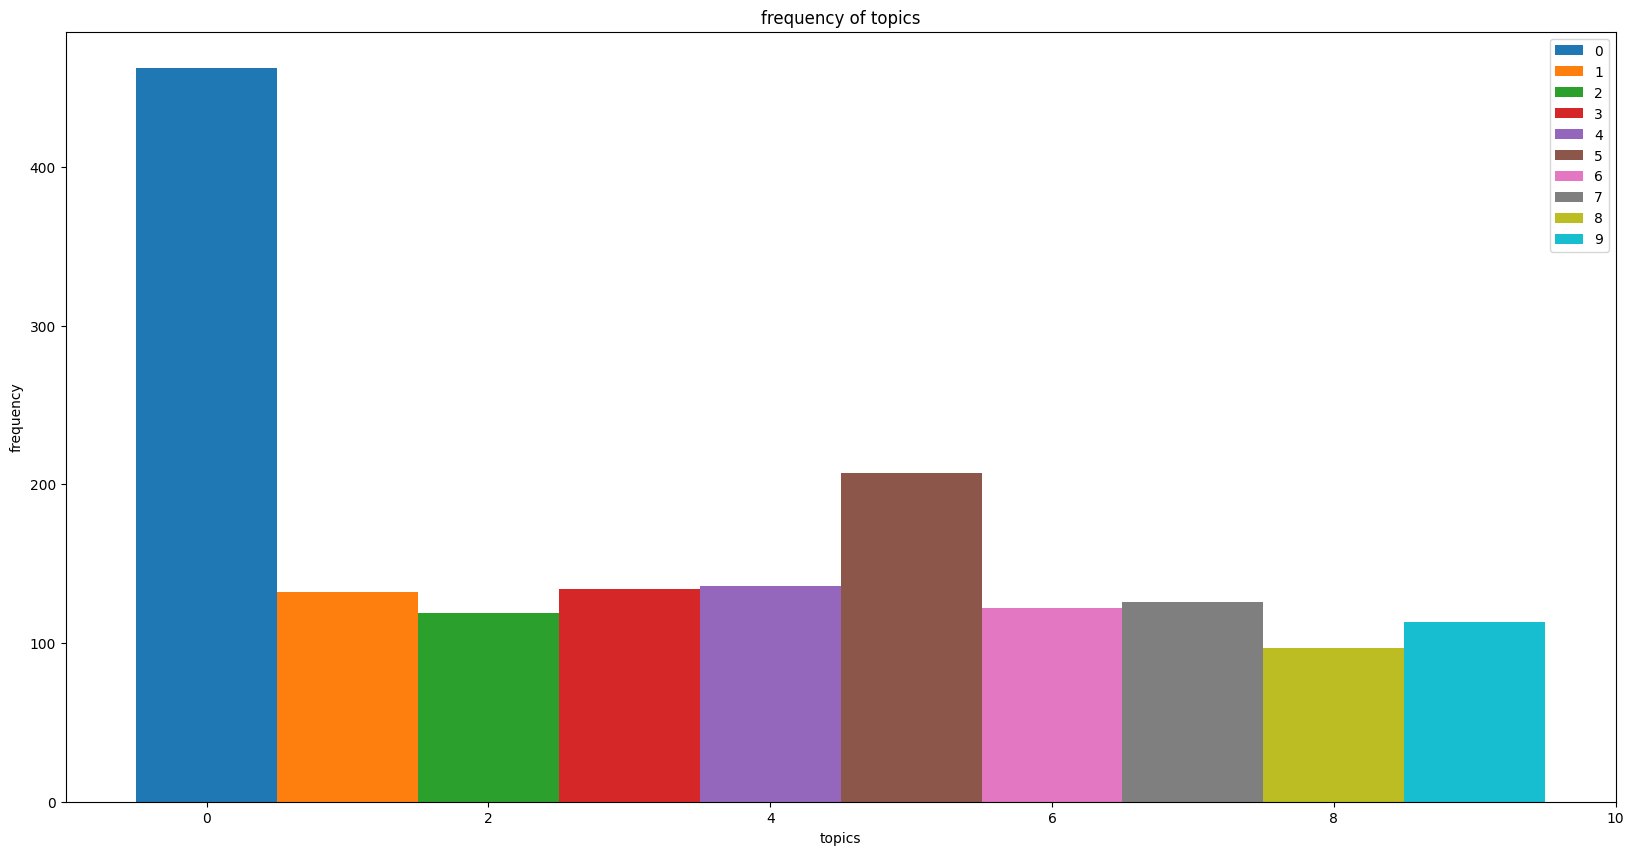

In [228]:
grouped = df.groupby("topic")
# Define the mapping from numerical values to categorical labels
plt.figure(figsize=(20, 10))
for name, group in grouped:
    plt.hist(group["topic"], bins=1, alpha=1, label=name)

plt.xlabel("topics")
plt.ylabel("frequency")
plt.title("frequency of topics")
plt.legend()
plt.show()


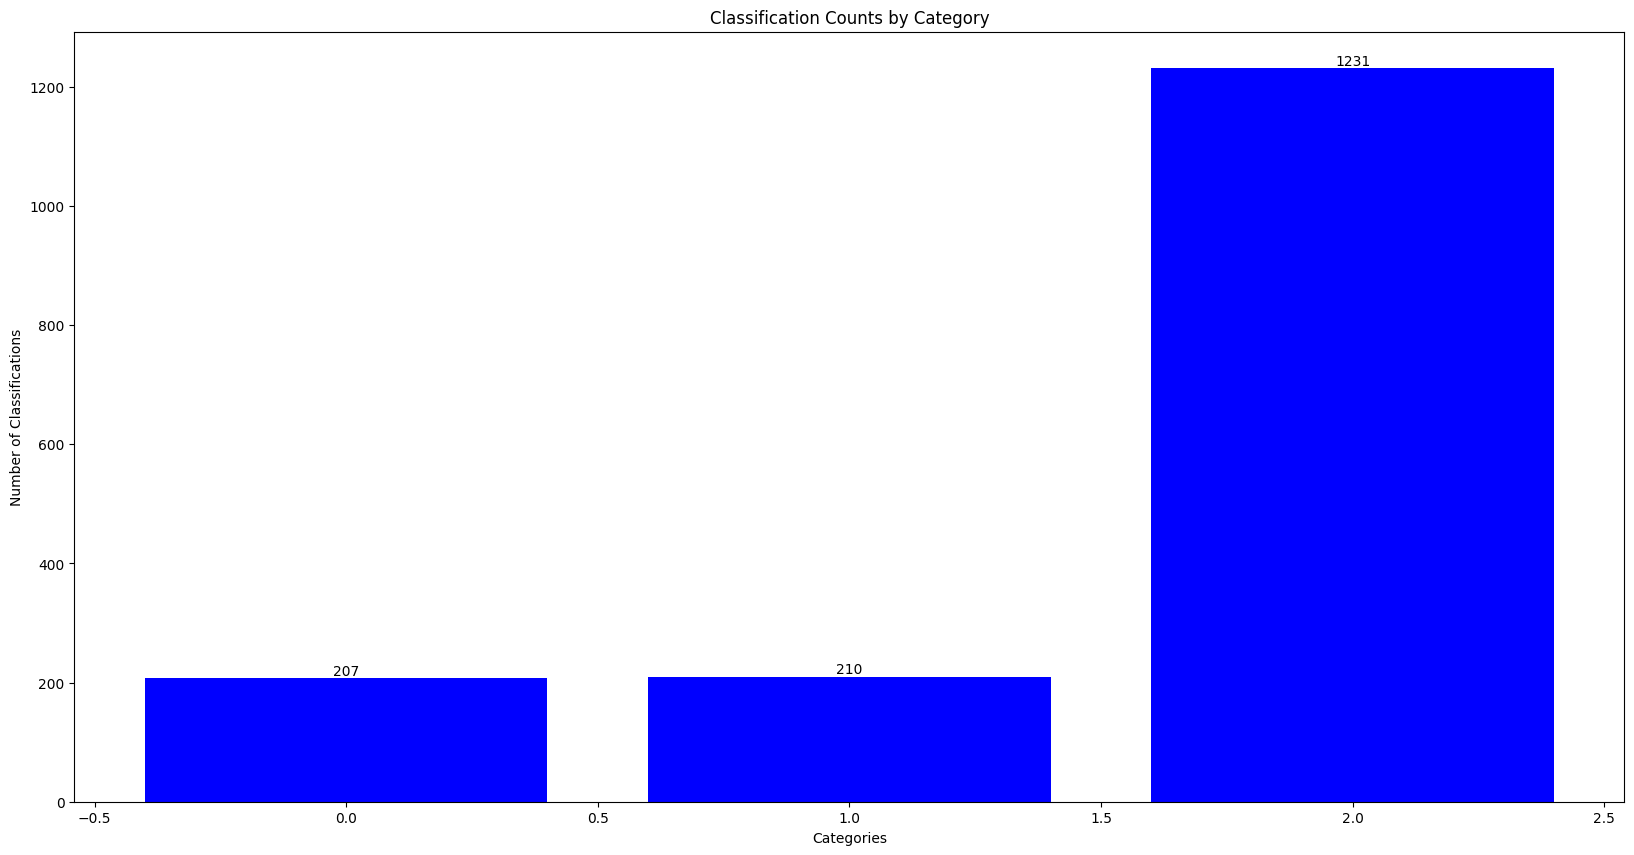

In [236]:

grouped = df.groupby('classification').size()

# Prepare data for the bar graph
categories = grouped.index
values = grouped.values

# Create the bar graph
plt.figure(figsize=(20, 10))
bars = plt.bar(categories, values, color='blue')

# Add titles and labels
plt.title('Classification Counts by Category')
plt.xlabel('Categories')
plt.ylabel('Number of Classifications')

# Label each bar with its frequency
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, int(height), ha='center', va='bottom',label=name)

# Show the bar graph
plt.show()


Classifier report
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        45
           1     1.0000    1.0000    1.0000        32
           2     1.0000    1.0000    1.0000       253

    accuracy                         1.0000       330
   macro avg     1.0000    1.0000    1.0000       330
weighted avg     1.0000    1.0000    1.0000       330



Text(50.722222222222214, 0.5, 'Actual Values ')

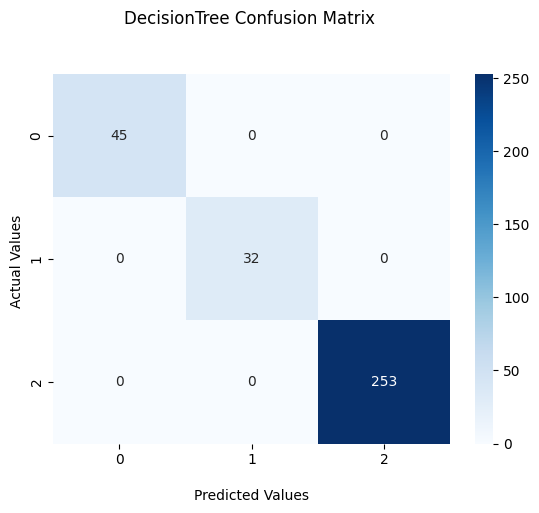

In [223]:


lab_encoder = preprocessing.LabelEncoder()
df['Column1'] = lab_encoder.fit_transform(df['Column1'])
df['topic'] = lab_encoder.fit_transform(df['topic'])
df['classification'] = lab_encoder.fit_transform(df['classification'])

features = [col for col in df.columns if col != 'classification']
# Prepare the feature matrix and target variable
X = df[features].values
sc = StandardScaler()
scaler = sc.fit(X)
X = scaler.transform(X)
y = df['classification'].values

# Split the data into training and testing sets
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.20)

clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, digits=4)
print('Classifier report')
print(report)


confusion = metrics.confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d')
ax.set_title('DecisionTree Confusion Matrix \n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')


